In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Supervised Learning**

In Supervised learning, you train the machine using data which is well "labeled." It means some data is already tagged with the correct answer. There are two main areas where supervised learning is useful: classification problems and regression problems.

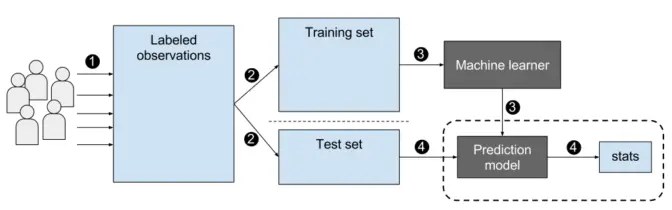


**Unsupervised Learning**
In unsupervised learning, a model is handed a dataset without explicit instructions on what to do with it. The training dataset is a collection of examples without a specific desired outcome or correct answer.
Common ways of dealing with Unsupervised learning problems include:
* Clustering

* Anomaly Detection

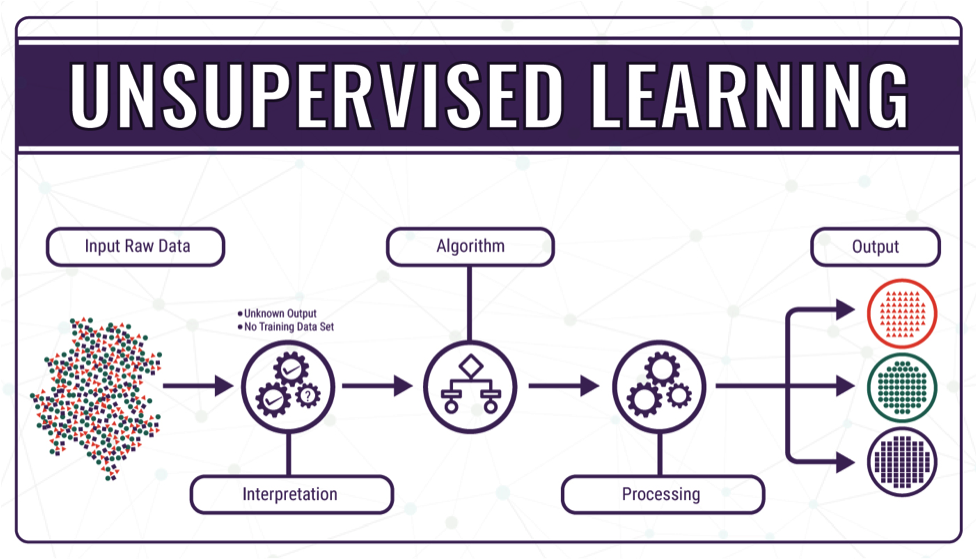


# Fraud Detection

A typical organization loses an estimated 5% of its yearly revenue to fraud. 
We will be looking at how to use data to investigate and fight fraud. 

You will learn:

1. how to deal with imbalanced data
2. how to apply supervised learning algorithms to detect fraudulent behavior similar to past ones, 
3. how to use unsupervised learning methods to discover new types of fraud activities. 
4. tips and advice from real-life experience to help you prevent making common mistakes in fraud analytics.

The main challenge with fraud data is that they are usually imbalanced. What this means is that we tend to have few fraud cases compared to the general population. We will look at ways of handling imbalanced data.  

In [ ]:
# Import all required libraries

import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

import gensim
from gensim import corpora

In [ ]:
# Configure Python

pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

In [ ]:
data = Path.cwd() / 'gdrive' / 'MyDrive' / 'Colab Notebooks' / 'LoughboroughUniversity' / 'data'

ch1 = data / 'chapter_1'
cc1_file = ch1 / 'creditcard_sampledata.csv'
cc3_file = ch1 / 'creditcard_sampledata_3.csv'

ch2 = data / 'chapter_2'
cc2_file = ch2 / 'creditcard_sampledata_2.csv'

ch3 = data / 'chapter_3'
banksim_file = ch3 / 'banksim.csv'
banksim_adj_file = ch3 / 'banksim_adj.csv'
db_full_file = ch3 / 'db_full.pickle'
labels_file = ch3 / 'labels.pickle'
labels_full_file = ch3 / 'labels_full.pickle'
x_scaled_file = ch3 / 'x_scaled.pickle'
x_scaled_full_file = ch3 / 'x_scaled_full.pickle'

ch4 = data / 'chapter_4'
enron_emails_clean_file = ch4 / 'enron_emails_clean.csv'
cleantext_file = ch4 / 'cleantext.pickle'
corpus_file = ch4 / 'corpus.pickle'
dict_file = ch4 / 'dict.pickle'
ldamodel_file = ch4 / 'ldamodel.pickle'

**Business Understanding**

The Risk Officer at your organisation has engaged you to tackle a problem within the business. The department has identified credit card fraud cases and will need your help to build a model that can automate this process of fraud detection.

For this example, we already have our dataset and so are not bothered about data extraction. However note that in real life, this may not always be the case.



In [ ]:
df = pd.read_csv(cc3_file)

**Data Exploration**


In [ ]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,258647,1.725265,-1.337256,-1.012687,-0.361656,-1.431611,-1.098681,-0.842274,-0.026594,-0.032409,0.215113,1.618952,-0.654046,-1.442665,-1.546538,-0.230008,1.785539,1.419793,0.071666,0.233031,0.275911,0.414524,0.793434,0.028887,0.419421,-0.367529,-0.155634,-0.015768,0.010790,189.00,0
1,69263,0.683254,-1.681875,0.533349,-0.326064,-1.455603,0.101832,-0.520590,0.114036,-0.601760,0.444011,1.521570,0.499202,-0.127849,-0.237253,-0.752351,0.667190,0.724785,-1.736615,0.702088,0.638186,0.116898,-0.304605,-0.125547,0.244848,0.069163,-0.460712,-0.017068,0.063542,315.17,0
2,96552,1.067973,-0.656667,1.029738,0.253899,-1.172715,0.073232,-0.745771,0.249803,1.383057,-0.483771,-0.782780,0.005242,-1.273288,-0.269260,0.091287,-0.347973,0.495328,-0.925949,0.099138,-0.083859,-0.189315,-0.426743,0.079539,0.129692,0.002778,0.970498,-0.035056,0.017313,59.98,0
3,281898,0.119513,0.729275,-1.678879,-1.551408,3.128914,3.210632,0.356276,0.920374,-0.160589,-0.801748,0.137341,-0.156740,-0.429388,-0.752392,0.155272,0.215068,0.352222,-0.376168,-0.398920,0.043715,-0.335825,-0.906171,0.108350,0.593062,-0.424303,0.164201,0.245881,0.071029,0.89,0
4,86917,1.271253,0.275694,0.159568,1.003096,-0.128535,-0.608730,0.088777,-0.145336,0.156047,0.022707,-0.963306,-0.228074,-0.324933,0.390609,1.065923,0.285930,-0.627072,0.170175,-0.215912,-0.147394,0.031958,0.123503,-0.174528,-0.147535,0.735909,-0.262270,0.015577,0.015955,6.53,0


In [ ]:
df.shape

(5050, 31)

In [ ]:
df.describe()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000
mean,142870.017030,-0.014675,0.044325,-0.035144,0.002494,-0.046625,-0.046340,-0.043020,-0.008398,-0.027331,-0.056943,0.035342,-0.052371,0.003131,-0.063824,-0.027567,-0.044949,-0.070704,-0.037026,-0.007536,-0.000940,-0.003516,-0.009421,-0.004147,-0.001200,-0.003314,-0.004836,-0.005726,0.002482,86.117232,0.009901
std,82574.683531,1.952784,1.558235,1.691458,1.493592,1.321320,1.254301,1.338170,1.323247,1.134506,1.278092,1.105792,1.259155,0.994961,1.190900,0.905586,1.031225,1.234009,0.894977,0.827070,0.715765,0.756735,0.724749,0.601276,0.599400,0.517363,0.481913,0.411055,0.302719,227.210259,0.099020
min,5.000000,-25.266355,-18.701995,-26.823673,-4.575708,-18.664251,-6.357009,-23.783470,-41.484823,-8.504285,-17.141514,-3.469084,-18.683715,-3.539561,-15.297656,-3.875765,-14.129855,-21.338195,-8.484449,-4.038451,-13.421949,-20.262054,-5.532541,-17.026156,-2.307453,-3.308049,-1.715640,-7.976100,-5.048979,0.000000,0.000000
25%,71817.750000,-0.926226,-0.589562,-0.873696,-0.871759,-0.733235,-0.777552,-0.571678,-0.211263,-0.651215,-0.541561,-0.752762,-0.438689,-0.639214,-0.462520,-0.601438,-0.490668,-0.490088,-0.508041,-0.471003,-0.212240,-0.231508,-0.558904,-0.161166,-0.354973,-0.316947,-0.331584,-0.070963,-0.052133,4.990000,0.000000
50%,142544.000000,0.009592,0.088726,0.168377,-0.027034,-0.060932,-0.304225,0.036753,0.000985,-0.052724,-0.109888,-0.032953,0.144052,-0.019056,0.032090,0.013126,0.064560,-0.077191,-0.021247,-0.004843,-0.062039,-0.035204,-0.013332,-0.011305,0.038272,0.019200,-0.059882,0.003521,0.012842,20.260000,0.000000
75%,215019.000000,1.310062,0.809298,1.017166,0.763626,0.603678,0.356664,0.594029,0.313264,0.568374,0.437051,0.759681,0.623239,0.683348,0.466251,0.607702,0.516420,0.389950,0.469353,0.458362,0.124908,0.196481,0.509243,0.146835,0.441278,0.348177,0.228486,0.095662,0.077357,75.000000,0.000000
max,284782.000000,2.422508,14.323254,3.760965,11.885313,9.880564,7.473970,9.288494,16.633103,8.054123,12.562347,9.939820,4.846452,3.579906,6.634483,3.363685,3.620831,6.024397,3.531250,4.851255,10.150611,19.283602,5.805795,13.218751,3.535179,3.590787,2.961609,4.623508,9.876371,4584.880000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5050 non-null   int64  
 1   V1          5050 non-null   float64
 2   V2          5050 non-null   float64
 3   V3          5050 non-null   float64
 4   V4          5050 non-null   float64
 5   V5          5050 non-null   float64
 6   V6          5050 non-null   float64
 7   V7          5050 non-null   float64
 8   V8          5050 non-null   float64
 9   V9          5050 non-null   float64
 10  V10         5050 non-null   float64
 11  V11         5050 non-null   float64
 12  V12         5050 non-null   float64
 13  V13         5050 non-null   float64
 14  V14         5050 non-null   float64
 15  V15         5050 non-null   float64
 16  V16         5050 non-null   float64
 17  V17         5050 non-null   float64
 18  V18         5050 non-null   float64
 19  V19         5050 non-null  

In [ ]:
df.Amount.sum()

434892.02

In [ ]:
# Count the occurrences of fraud and no fraud
df['Class'].value_counts()

0    5000
1      50
Name: Class, dtype: int64

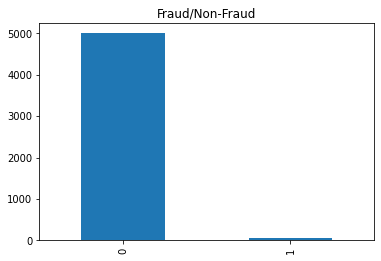

In [ ]:
df['Class'].value_counts().plot(kind = 'bar', title = 'Fraud/Non-Fraud')

As seen, the ratio of fraudulent transactions is very low.

Visualizations help us to immediately 'see' our data and highlight things we may not see in the raw data. Visualizations are also helpful when presenting to stakeholders.

Let's visualize our data

In [ ]:
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df.iloc[:, 2:30].values
    y = df.Class.values
    return X, y

In [ ]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5,
                linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5,
                linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [ ]:
# Create X and y from the prep_data function 
X, y = prep_data(df)

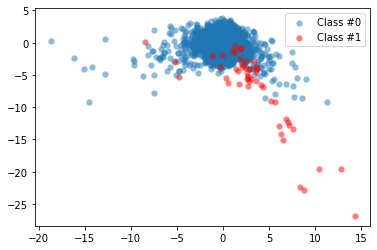

In [ ]:
# Plot our data by running our plot data function on X and y
plot_data(X, y)

By visualizing the data, you can immediately see how our fraud cases are scattered over our data, and how few cases we have. A picture often makes the imbalance problem clear. In the next exercises we'll visually explore how to improve our fraud to non-fraud balance.

**Increase successful detections with data resampling**

* Undersampling the majority class (non-fraud cases)
* Straightforward method to adjust imbalanced data
* Take random draws from the non-fraud observations, to match the occurences of fraud observations (as shown in the picture)

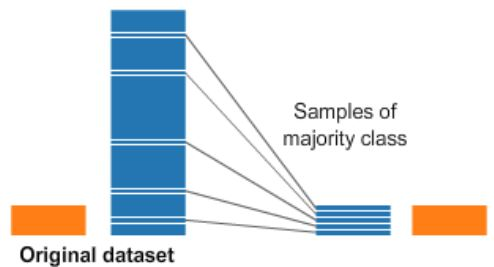

* Oversampling the minority class (fraud cases)
* Take random draws from the fraud cases and copy those observations to increase the amount of fraud samples
* Both methods lead to having a balance between fraud and non-fraud cases

**Drawbacks**
* with random undersampling, a lot of information is thrown away
* with oversampling, the model will be trained on a lot of duplicates





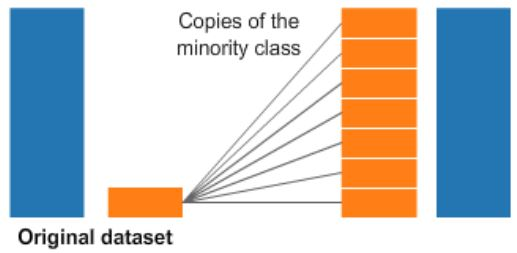

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


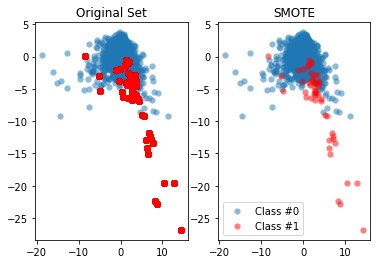

In [ ]:
from imblearn.over_sampling import RandomOverSampler

method = RandomOverSampler()
X_resampled, y_resampled =  method.fit_sample(X, y)

compare_plots(X_resampled, y_resampled, X, y, method = 'SMOTE')

In [ ]:
# Class count
count_class_0, count_class_1 = df.Class.value_counts()

# Divide by class
df_class_0 = df[df['Class'] == 0]
df_class_1 = df[df['Class'] == 1]

**Random Undersampling**

Random under-sampling:
1    50
0    50
Name: Class, dtype: int64


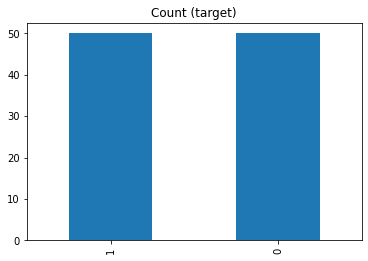

In [ ]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.Class.value_counts())

df_test_under.Class.value_counts().plot(kind='bar', title='Count (target)');

**Random Oversampling**

Random over-sampling:
1    5000
0    5000
Name: Class, dtype: int64


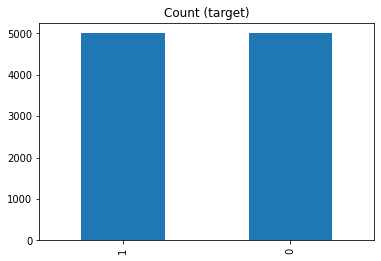

In [ ]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Class.value_counts())

df_test_over.Class.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

**Python's imblean library**

Python's imblean library allows us to cluster the records of the majority class, and 

* do the under-sampling by removing records from each cluster, thus seeking to preserve information. 

* instead of creating exact copies of the minority class records when we oversample, we can introduce small variations into those copies, creating more diverse synthetic samples.

4950 new random picked points


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


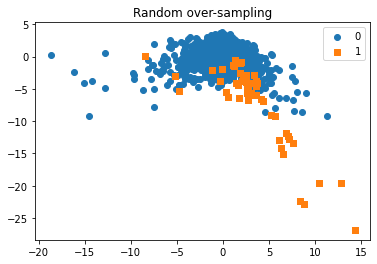

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

Removed indexes: [2421 1919 1431 3839 1890 4539 3580 1679 4814 3520   77  298 3436 4019
  188 1580  509 4073 3473  321 3595 3526 4514 2673 3510 4653 3556  520
 3280 4309 4847 2290 4135 1129 1852 2181 4609 2506 1223  741 3969 3264
 2962 3530 1028  936 3324 3750  301 1591 5000 5001 5002 5003 5004 5005
 5006 5007 5008 5009 5010 5011 5012 5013 5014 5015 5016 5017 5018 5019
 5020 5021 5022 5023 5024 5025 5026 5027 5028 5029 5030 5031 5032 5033
 5034 5035 5036 5037 5038 5039 5040 5041 5042 5043 5044 5045 5046 5047
 5048 5049]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


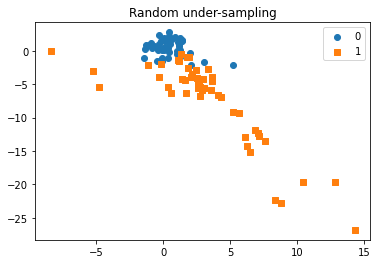

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)

print('Removed indexes:', id_rus)

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

**Which method is best?**

All depends on your context. Take it case by case basis. However, only resample on your TRAINING set!

Random Undersampling (RUS):
* If there is a lot of data and many minority cases, then undersampling may be computationally more convenient
* However, throwing away data is not desirable

Random Oversampling (ROS):
* Straightforward
* Training the model on many duplicates



**Synthetic Minority Oversampling Technique (SMOTE)**

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

"… *SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.*" ( [Nitesh Chawla, et al. 2002](https://arxiv.org/abs/1106.1813))

SMOTE is more sophisticated compared to the previous methods discussed and is widely used in industry. Note however that we will be building our models on fake data.

Let's apply SMOTE to our data

In [ ]:
X, y = prep_data(df)
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (5050, 28)
y shape: (5050,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


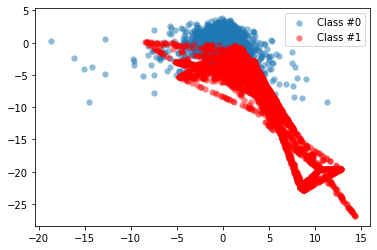

In [ ]:
# Define the resampling method
res_model = SMOTE()

# Create the resampled feature set
X_resampled, y_resampled = res_model.fit_sample(X, y)

# Plot the resampled data
plot_data(X_resampled, y_resampled)

As we can see, the minority class is now more visible in our data.

In [ ]:
# Compare SMOTE data to original data
pd.value_counts(pd.Series(y))

0    5000
1      50
dtype: int64

In [ ]:
pd.value_counts(pd.Series(y_resampled))

1    5000
0    5000
dtype: int64

In [ ]:
def compare_plot(X: np.ndarray, y: np.ndarray, X_resampled: np.ndarray, y_resampled: np.ndarray, method: str):
    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title('Original Set')
    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[y_resampled == 0, 0],
                X_resampled[y_resampled == 0, 1], label="Class #0",
                alpha=0.5, linewidth=0.15)
    plt.scatter(X_resampled[y_resampled == 1, 0],
                X_resampled[y_resampled == 1, 1], label="Class #1",
                alpha=0.5, linewidth=0.15, c='r')
    plt.title(method)
    plt.legend()
    plt.show() 

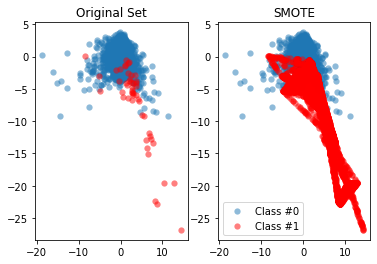

In [ ]:
compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')


SMOTE has not only helped in balancing our data, it has also maintained the distribution of the original data.

# Build Machine learning Model

Fraud detection algorithms can be rule based or ML models. Rule based models are easier to implement hence quicker and can be a first layer implementation based on business needs.

Machine learning models have advantages over rule based models:

1. Ability to adapt to changing data over time.
2. Learn the interaction between features rather than use one feature at a time
3. Better performance in terms of accuracy
4. Can give a score rather than binary result

**Steps in building a model:**
1. Split data into training and testing data
2. Define your model - Linear regression/boosting models/etc
2. Build the model on the training data
3. Test the model on the test data
4. Record the performance of the model

In [ ]:
# Step 1: split the features and labels into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 2)

In [ ]:
# Step 2: Define which model to use
model = LogisticRegression(solver='liblinear')

In [ ]:
# Step 3: Fit the model to the training data
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Step 4: Obtain model predictions from the test data
y_predicted = model.predict(X_test)

In [ ]:
# Step 5: Record the performance of the model
r2_score(y_test, y_predicted)

0.689644576462153

In [ ]:
# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1502
           1       0.85      0.85      0.85        13

    accuracy                           1.00      1515
   macro avg       0.92      0.92      0.92      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix:
 [[1500    2]
 [   2   11]]


**False Positives:** 2

**True Positives:** 11

**True Negatives:** 1500

**False Negatives:** 2 

In [ ]:
y_test.shape

(1515,)

Rule Based Method

In [ ]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df.groupby('Class').mean()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.035030,0.011553,0.037444,-0.045760,-0.013825,-0.030885,0.014315,-0.022432,-0.002227,0.001667,-0.004511,0.017434,0.004204,0.006542,-0.026640,0.001190,0.004481,-0.010892,-0.016554,-0.002896,-0.010583,-0.010206,-0.003305,-0.000918,-0.002613,-0.004651,-0.009584,0.002414,85.843714
1,-4.985211,3.321539,-7.293909,4.827952,-3.326587,-1.591882,-5.776541,1.395058,-2.537728,-5.917934,4.020563,-7.032865,-0.104179,-7.100399,-0.120265,-4.658854,-7.589219,-2.650436,0.894255,0.194580,0.703182,0.069065,-0.088374,-0.029425,-0.073336,-0.023377,0.380072,0.009304,113.469000


In [ ]:
df['flag_as_fraud'] = np.where(np.logical_and(df.V1 < -3, df.V3 < -5), 1, 0)

In [ ]:
pd.crosstab(df.Class, df.flag_as_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud'])

Flagged Fraud,0,1
Actual Fraud,,
0,4984,16
1,28,22


**False Positives:** 16

**True Positives:** 22

**True Negatives:** 4984

**False Negatives:** 28

**Random Forest Classifier**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
# Define the model as the random forest
model = RandomForestClassifier(random_state=5, n_estimators=20)

In [ ]:
# Fit the model to our training set
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [ ]:
# Obtain predictions from the test data 
predicted = model.predict(X_test)

In [ ]:
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted):0.3f}')

Accuracy Score:
0.998


In [ ]:
# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1505
           1       0.89      0.80      0.84        10

    accuracy                           1.00      1515
   macro avg       0.94      0.90      0.92      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix:
 [[1504    1]
 [   2    8]]


**False Positives:** 1

**True Positives:** 8

**True Negatives:** 1504

**False Negatives:** 2